In [22]:
!pip install pyarrow


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


## Q1. Downloading the data
We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "Yellow Taxi Trip Records".

Download the data for January and February 2023.

Read the data for January. How many columns are there?

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [24]:
df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [25]:
# Total number of rows and columns
num_rows = df.shape[0]
num_cols = df.shape[1]

# Print the values
print(f"Total rows: {num_rows}")
print(f"Total columns: {num_cols}")
print(f"Shape: {df.shape}")


Total rows: 3066766
Total columns: 19
Shape: (3066766, 19)


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

## Q2. Computing duration
Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?

In [27]:
# Compute duration in minutes
df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Compute the standard deviation
std_duration = df['duration'].std()
print(f"Standard deviation of trip duration in January 2023: {std_duration:.2f} minutes")

Standard deviation of trip duration in January 2023: 42.59 minutes


## Q3. Dropping outliers
Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

In [28]:
initial_count = len(df)
df_filtered = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
filtered_count = len(df_filtered)
fraction_remaining = filtered_count / initial_count
print(f"Fraction of records remaining after removing outliers: {fraction_remaining:.3f}")

Fraction of records remaining after removing outliers: 0.981


## Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
- Fit a dictionary vectorizer
- Get a feature matrix from it
  
What's the dimensionality of this matrix (number of columns)?

In [29]:
from sklearn.feature_extraction import DictVectorizer

# Recast location IDs to string (important for one-hot encoding)
df_filtered['PULocationID'] = df_filtered['PULocationID'].astype(str)
df_filtered['DOLocationID'] = df_filtered['DOLocationID'].astype(str)

# Turn DataFrame into list of dictionaries
dicts = df_filtered[['PULocationID', 'DOLocationID']].to_dict(orient='records')

# Fit DictVectorizer
dv = DictVectorizer()
X = dv.fit_transform(dicts)

# Print dimensionality
print(f"Shape of feature matrix: {X.shape}")
print(f"Number of features (columns): {X.shape[1]}")


/tmp/ipykernel_51790/2245053062.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['PULocationID'] = df_filtered['PULocationID'].astype(str)
/tmp/ipykernel_51790/2245053062.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['DOLocationID'] = df_filtered['DOLocationID'].astype(str)


Shape of feature matrix: (3009173, 515)
Number of features (columns): 515


In [30]:
# Show the first 5 feature names
print("Feature names (first 5):")
print(dv.get_feature_names_out()[:5])

# Convert sparse matrix to dense array 
X_dense = X[:5].toarray()

# Show values of the first 5 encoded rows
print("\nOne-hot encoded feature matrix (first 5 rows):")
print(X_dense)

Feature names (first 5):
['DOLocationID=1' 'DOLocationID=10' 'DOLocationID=100' 'DOLocationID=101'
 'DOLocationID=102']

One-hot encoded feature matrix (first 5 rows):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters, where duration is the response variable
Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [31]:
# Define the target variable (duration)
y_train = df_filtered['duration'].values

# Train a plain linear regression model
model = LinearRegression()
model.fit(X, y_train)

LinearRegression()

In [32]:
# Predict on training data
y_pred = model.predict(X)

In [33]:
# Calculate RMSE
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE on training data: {rmse:.2f} minutes")

RMSE on training data: 7.65 minutes


/tmp/ipykernel_51790/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_51790/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


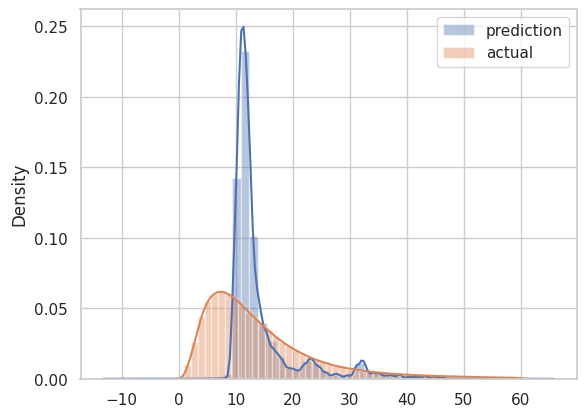

In [34]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

## Q6. Evaluating the model
Now let's apply this model to the validation dataset (February 2023).

What's the RMSE on validation?

In [41]:
def read_dataframe(file_path):
    """
    Read a parquet file and preprocess the dataframe.
    """
    df = pd.read_parquet(file_path)
    # Compute duration in minutes
    df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
    
    # Filter out durations between 1 and 60 minutes
    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
    
    # Recast location IDs to string for one-hot encoding
    df['PULocationID'] = df['PULocationID'].astype(str)
    df['DOLocationID'] = df['DOLocationID'].astype(str)
    
    return df


In [39]:
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2855951 entries, 0 to 2913954
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           object        
 8   DOLocationID           object        
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee            floa

In [ ]:
dicts_val = df_val[['PULocationID', 'DOLocationID']].to_dict(orient='records')
X_val = dv.transform(dicts_val)  # ← Use transform, not fit_transform
y_val = df_val['duration'].values

# Predict using the trained model
y_pred_val = model.predict(X_val)

In [ ]:
# Compute RMSE for validation
mse_val = mean_squared_error(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)
# Output the RMSE on validation data
print(f"RMSE on validation data: {rmse_val:.2f} minutes")